In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

# Week 9 (Wednesday), AST 8581 / PHYS 8581 / CSCI 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>, Jie Ding <dingj@umn.edu>


with contributions totally ripped off from Gautham Narayan (UIUC), Michael Steinbach (UMN), and Nico Adams (UMN)


## More clustering, Density Estimation

# Where do we stand?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability) -> Analysis of Time series (stochastic processes) -> Gaussian Processes -> Decision Trees / Regression -> Dimensionality Reduction -> Principle Component Analysis -> Clustering

## Recap

- ML is broadly divided into supervised and unsupervised methods
- Supervised = you've got labels for the data you are trying to predict, unsupervised = you don't 

- Unsupervised methods then are about finding structure in the data itself
    - clustering is trying to find group similar samples in your dataset
    - you need some measure of distance to define similarity - a **metric**
    
- To effectively use clustering algorithms, you have to limit the number of dimensions or your metric isn't useful
    - viewed as an optimization problem, clustering (like all problems) gets hard to solve as the number of dimensions gets large
    - viewed as a density problem, as the number of dimensions gets large, the fractional volume within some hypersphere becomes 0 
        - i.e. your cluster isn't likely to enclose many points, because as the dimensionality grows, samples themselves are spread further apart

- To tackle this we use **dimensionality reduction** 
    - **Principal Component Analysis** - express your data as a sum of orthogonal eigenvectors constructed such that (hopefully) a few eigenvectors explain most of the variance of the data
        - linear methods don't necessarily work well for non-linear structure in the data but are invertible
    - ```astronomers will often try to derive physical insight from PCA eigenspectra or eigentimeseries, but this is not advisable as there is no physical reason for the data to be linearly and orthogonally separable``` - snark from Adam Miller (Northwestern)
    - there are non-linear methods - manifold learning (i.e. IsoMaps)/LLE/autoencoders and variants  

- Once you have some reasonably low-dimensional representation of your data:    
        - k-means: splits dataset into $k \sim$ approximately equally sized clusters by finding the mean cluster centers using MSE as a metric
        - GMMs: splits dataset into a sum of $k$ Gaussians (you don't have to use Gaussians but the likelihood/metric is easy)
- in both cases, for each sample in the dataset, we're creating a latent variable which encodes cluster membership 
- clustering can be viewed as a hierarchical model where the cluster parameters specify the population


- **Expectation Maximiation** - hold cluster membership fixed, update population parameters, then hold population parameters fixed and update cluster membership 

## Clustering isn't just finding groups of things that are similar

What you are doing is specifying a **parametric** model for the **density of the data** 

This is usually a better use for clustering algorithms - the cluster centers and sizes may not be useful/physically meaningful, but the sum of all the components is a representation of the underlying density field reconstructed from sparse samples:

Our Universe is only isotropic and homogenous on the largest scales - when you smooth over filaments in the cosmic web:

<img src="figures/galaxy_map.gif" width="70%">

## Demo: The use of GMMs as a tool for density estimation

- We'll use the Sloan Dataset to estimate density with k=50 and k=200 GMMs
- Look at how clusters in the data (i.e. look at your data and identify these by eye) map to centers of Gaussians
- And look at how the GMM traces the overall density

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from astroML.datasets import fetch_great_wall
from astroML.utils.decorators import pickle_results
from sklearn.neighbors import KernelDensity

# In-Class warm-up: Clustering

Play with the Gaussian Mixture parameter n_clusters (representing the number of clusters) to see what looks reasonable.

In [2]:
# load great wall data
X = fetch_great_wall()


def compute_GMM(n_clusters, max_iter=1000, tol=3, covariance_type='full'):
    clf = GaussianMixture(n_clusters, covariance_type=covariance_type,
                          max_iter=max_iter, tol=tol, random_state=0)
    clf.fit(X)
    return clf

#------------------------------------------------------------
# Compute a grid on which to evaluate the result
Nx = 100
Ny = 250
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

clf1 = compute_GMM(...
clf2 = compute_GMM(...
log_dens1 = clf1.score_samples(Xgrid).reshape(Ny, Nx)
log_dens2 = clf2.score_samples(Xgrid).reshape(Ny, Nx)

/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


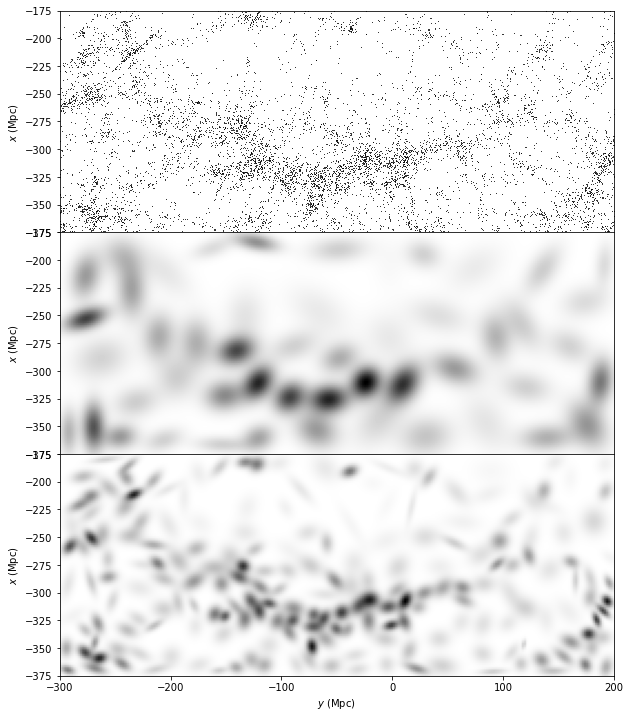

In [3]:
# Plot the results
fig = plt.figure(figsize=(10, 12))
fig.subplots_adjust(hspace=0, left=0.08, right=0.95, bottom=0.13, top=0.9)

ax = fig.add_subplot(311, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)

ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.ylabel(r'$x\ {\rm (Mpc)}$')

ax = fig.add_subplot(312, aspect='equal')
ax.imshow(np.exp(log_dens1.T), origin='lower', cmap=plt.cm.binary,
          extent=[ymin, ymax, xmin, xmax])
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel(r'$x\ {\rm (Mpc)}$')

ax = fig.add_subplot(313, aspect='equal')
ax.imshow(np.exp(log_dens2.T), origin='lower', cmap=plt.cm.binary,
          extent=[ymin, ymax, xmin, xmax])
ax.set_xlabel(r'$y\ {\rm (Mpc)}$')
ax.set_ylabel(r'$x\ {\rm (Mpc)}$')

plt.show()

## KDEs

Mixture models are really useful for estimating density (you can still use them for clustering, but you've got to work to interpret what the clusters are and how many you need)

While a mixture model is parametric, you can take the extreme limit of making the number of clusters = the number of datapoints, and instead of treating the mean as a parameter, use the value of the data itself as the mean. 

To simplify things further, we'll assume all the components of the mixture have the same scale/$\sigma$ or more generally a **bandwidth** - which you specify 

This is called **kernel density estimation** 

A common kernel is the (YOU GUESSED IT) Gaussian kernel that we just used above:

$$K(u) = \frac{1}{(2\pi)^{D/2}}\exp^{-u^2/2}$$


Once a kernel is chosen the kernel density estimate at a given point, $x$, is given by 

$$ \rho(x) = \frac{1}{Nh^D}\sum_{i=1}^N K\left(\frac{d(x,x_i)}{h}\right),$$ where $\rho(x)$ is an estimator of our distribution.

## Where does this come from? 

If you wanted to know the density of points you could compute 

$$\frac{\sum_1^N\delta (x-x_i)}{V}$$ 

where $\delta (x-x_i)$ is the Delta function, $V$ is the volume, and $N$ is the number of points. 

In $D$-dimensional space a volume element is just $h^D$. Then instead of representing our observation as a delta function, we represent it by our kernel function. To normalize for the number of points, divide by $N$.

The argument of $K$ is just some measure of the distance between $x$ and each $x_i$. 

Normally $d(x,x_i) = (x-x_i)$. For the gaussian kernel that makes $h=\sigma$.

In [4]:
# CHANGE PARAMETERS FOR KERNEL, METRIX AND BANDWIDTH AS YOU LIKE
kde = KernelDensity(bandwidth=5, kernel='gaussian', metric='euclidean')
kde.fit(X)
log_dens3 = kde.score_samples(Xgrid).reshape(Ny, Nx)

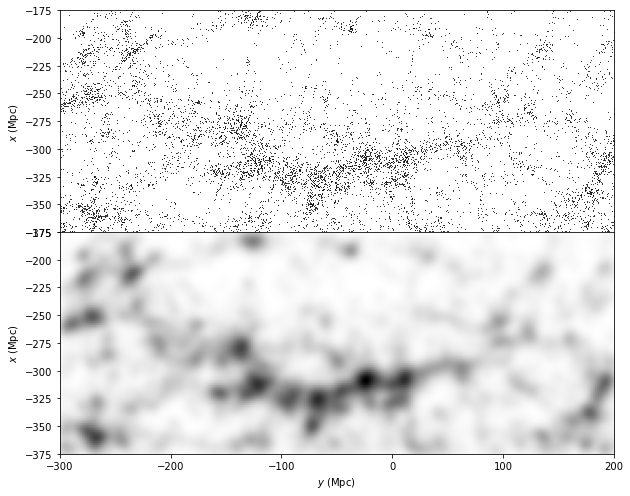

In [5]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(hspace=0, left=0.08, right=0.95, bottom=0.13, top=0.9)

ax = fig.add_subplot(211, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)

ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.ylabel(r'$x\ {\rm (Mpc)}$')

ax = fig.add_subplot(212, aspect='equal')
ax.imshow(np.exp(log_dens3.T), origin='lower', cmap=plt.cm.binary,
          extent=[ymin, ymax, xmin, xmax])


ax.set_xlabel(r'$y\ {\rm (Mpc)}$')
ax.set_ylabel(r'$x\ {\rm (Mpc)}$')

plt.show()

You can view this as a **convolution** operation - just as with the 2D PSF and single source, you are convolving each point with a kernel (shape, metric and bandwidth is what you specify) 

You then sum up all the kernels and get a model for the underlying density field - just as with a GMM. 

The distinction is that with GMMs you were specifying a parametric model for the **population**

Here, *just as with the kernel in Gaussian Processes* you are specifying how points are correlated with each other in the density field.

And just as with Gaussian processes, you've got several potential choices for kernels. Common ones are below:

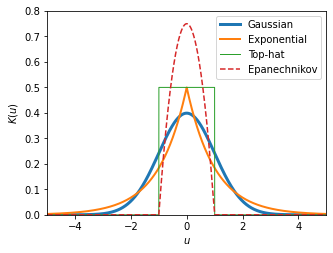

In [6]:
import numpy as np
from matplotlib import pyplot as plt

#------------------------------------------------------------
# Compute Kernels.
u = np.linspace(-5, 5, 10000)
du = u[1] - u[0]

gauss = (1. / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u ** 2)

exp = 0.5 * np.exp(-abs(u))

tophat = 0.5 * np.ones_like(u)
tophat[abs(u) > 1] = 0 # Range of the tophat kernel

ep = (3/4.)*(1-u**2)  
ep[abs(u)>1]=0 # Set the range of the Epanechnikov kernel

#------------------------------------------------------------
# Plot the kernels
fig = plt.figure(figsize=(5, 3.75))
ax = fig.add_subplot(111)

ax.plot(u, gauss, '-', c='C0', lw=3, label='Gaussian')
ax.plot(u, exp, '-', c='C1', lw=2, label='Exponential')
ax.plot(u, tophat, '-', c='C2', lw=1, label='Top-hat')
ax.plot(u,ep,'--',c='C3',label='Epanechnikov')  
ax.legend(loc=1)

ax.set_xlabel('$u$')
ax.set_ylabel('$K(u)$')

ax.set_xlim(-5, 5)
ax.set_ylim(0, 0.8001)
plt.show()

Nonparametric density estimation is useful when we know nothing about the underlying population distribution of the data since we don't have to specify a model (again, just as in Gaussian processes).

This flexibility allows us to capture the shape of the distribution well, at the expense of more difficulty interpreting the results.

## Why should I care about density estimates anyway and what has this got to do with machine learning???

You can draw new samples from density fields - i.e. you can simulate new data given a density estimate constructed on other data - i.e. you can use if for **data augmentation**

Also note that PDFs are just density fields - you can use KDEs to get smooth representations of the underlying PDF (you've already done this multiple times this semester) - and you know that sampling PDFs is sorta useful...

## But why go through all this - can't I just histogram the data to get an estimate of the density???

Sure, histograms are useful, but they're also risky - look at what happens when we adjust bins below:

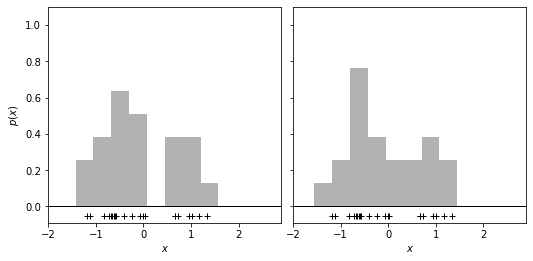

In [7]:
# Draw the random data
np.random.seed(1)
x = np.concatenate([np.random.normal(-0.5, 0.3, size=14), np.random.normal(1, 0.3, size=7)])


# First figure: silly histogram binning
fig1 = plt.figure(figsize=(8, 4))
fig1.subplots_adjust(left=0.12, right=0.95, wspace=0.05, bottom=0.15, top=0.9, hspace=0.05)


XLIM = (-2, 2.9)
YLIM = (-0.09, 1.1)

ax = fig1.add_subplot(121)
bins = np.linspace(-1.8, 2.7, 13)
ax.hist(x, bins=bins, density=True, histtype='stepfilled', fc='k', alpha=0.3)
ax.plot(XLIM, [0, 0], '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

#Shift bin centers by 0.25
ax = fig1.add_subplot(122)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.hist(x, bins=bins + 0.25, density=True, histtype='stepfilled', fc='k', alpha=0.3)
ax.plot(XLIM, [0, 0], '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')

plt.show()


The underlying distribution in both panels is the same, that is the data points that make up the histogram are the same. All we have done is shifted the locations of the bins by 0.25.

KDEs take away one of the issues - where the bins are - but you still are left with how to choose the bandwidth for the KDE (analogous to chosing the bin-width for the histogram) and you have a new issue - how to choose the kernel

Text(0.5, 0, '$x$')

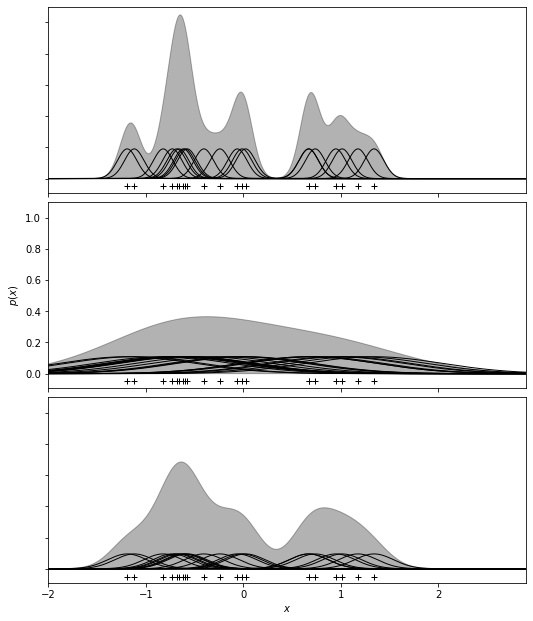

In [8]:
from scipy import stats
fig2 = plt.figure(figsize=(8, 8))
fig2.subplots_adjust(left=0.12, right=0.95, wspace=0.05, bottom=0.0, top=1.0, hspace=0.05)

ax = fig2.add_subplot(311)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], 0.1)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)

ax = fig2.add_subplot(312)
ax.xaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], 0.7)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, 4 * y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_ylabel('$p(x)$')
ax.set_xlabel('$x$')

ax = fig2.add_subplot(313)
ax.yaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], 0.2)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')

This looks better, but gives us a "Goldilocks" problem. The first plot uses a kernel that is too narrow. The second is too wide. The third is "just right".

#### The crucial part of KDE is to determine the optimal value for the width of the kernel.

We can empirically determine the optimal bandwidth through **cross validation** 

## Cross-Validation

Cross validation is related to the construction of training and test sets that we talked about last time (see week 11). Except now we're using the same idea in the context of unsupervised learning (and you can use it for for all of the first half of the semester, not just ML)

There are a number of different ways to do **cross-validation**. For example, you could randomly sample to decide which data goes into the training or test sets: 

<img src="http://i.stack.imgur.com/4Lrff.png" width="60%">

Where we aren't just doing this once, but rather many times so that each data point is treated both as a training point and as a test point.

We could do this in a more ordered way (e.g., to make sure that each point gets sampled as training/test the same number of times) and do a $K$-fold cross validation.  Here $K$ is the number of "experiments" that need to be done so that each data point appears in a test sample once.

<img src="http://i.stack.imgur.com/fhMza.png" width="60%">

We can take that to the extreme by having $K\equiv N$, so that in each experiment we leave out just one object.  This is called "Leave-One-Out" cross validation:

<img src="http://images.slideplayer.com/16/4977882/slides/slide_35.jpg" width="60%">

We can implement this in `sklearn` with `GridSearchCV` and replot our histogram:

In [9]:
# Complete and Execute this cell to determine the bandwidth

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
bwrange = np.linspace(0.1, 1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) 
grid.fit(x[:, None]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.1310344827586207


(-0.09, 1.1)

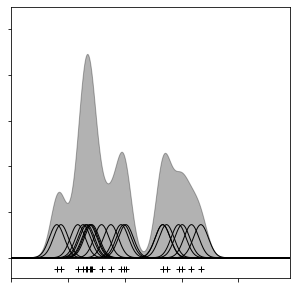

In [10]:
# Execute this cell to see the new "histogram"
fig2 = plt.figure(figsize=(5, 5))
ax = fig2.add_subplot(111)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], h_opt)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)

OK, so we've gone from $k$ clusters to replacing each data point with it's own kernel representing points in the underlying latent density field that are clustered with it. 

This was good for density estimation, but sometimes we do actually want clustering - grouping similar objects together. 

So it's reasonable to ask if this non-parametric density estimation technique can be converted back to clustering like we had with $k$-means and GMMs.

## Hierarchical Clustering

In Hierarchical Clustering, we don't specify the number of clusters ahead of time, we start with $N$ clusters representing each data point. 

Then the most similar clusters are joined together, the process repeating until some threshhold is reached.


<img src="figures/Hierarchical-clustering-2.png">

Clusters are merged at each step according to which are "nearest" to each other---where the definition of nearest needs to be specified - i.e. you still need a **metric** and your output is going to depend on how you make this choice.

After selecting a distance metric, it is necessary to determine from **where** distance is computed. 
    - Can be computed between the two most similar parts of a cluster (single-linkage), 
    - the two least similar bits of a cluster (complete-linkage)
    - the center of the clusters (mean or average-linkage)
    ....

As with distance metrics, the choice of linkage criteria should be made based on domain knowledge. 

**What causes variation between groups**

The default is just reducing the sum of squared distances of each observation from the average observation in a cluster. 

Some threshhold needs to be specified to tell the process where to stop clustering - i.e. the usual bias variance tradeoff - you can grow your tree upwards to where all points are clustered, but this may not be useful.

The typical choice for distance (Euclidean) and linkage criterion (average) results in what is called a **"minimum spanning tree"** 

You can of course visualize this minimum spanning tree and the result is a **dendrogram** just as you saw with decision trees.

# In-Class Exercise: Clustering

Play with the HierarchicalClustering parameters (n_neighbors, edge_cutoff, cluster_cutoff) to explore this trade-off.

In [11]:
from scipy import sparse
from astroML.clustering import HierarchicalClustering, get_graph_segments

X = fetch_great_wall()

xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Compute the MST clustering model

# YOUR CODE HERE
n_neighbors = ...
edge_cutoff = ...
cluster_cutoff = ...
model = HierarchicalClustering(...
                            
model.fit(X)
print(" scale: %2g Mpc" % np.percentile(model.full_tree_.data,
                                        100 * edge_cutoff))

n_components = model.n_components_
labels = model.labels_



#------------------------------------------------------------
# Get the x, y coordinates of the beginning and end of each line segment
T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)

Nx = 100
Ny = 250
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T


total_dens = None



for i in range(n_components):
    ind = (labels == i)
    Npts = ind.sum()
    Nclusters = int(min(12, Npts / 5))
    clf = compute_GMM(n_clusters=Nclusters)
    log_dens = clf.score_samples(Xgrid).reshape(Ny, Nx)
    dens = np.exp(log_dens)
    if total_dens is None:
        total_dens = dens
    else:
        total_dens += dens


density = total_dens

 scale: 3.54953 Mpc


/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


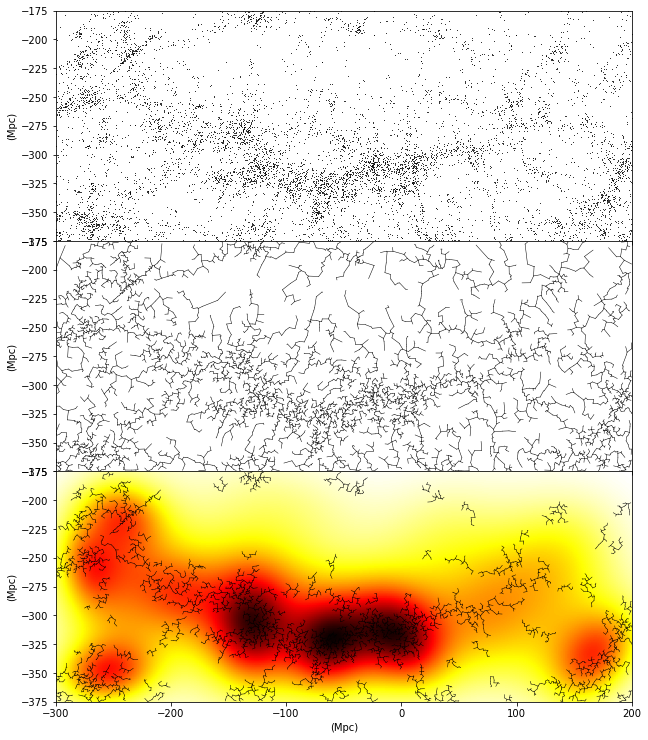

In [12]:
#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 12))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(312, aspect='equal')
ax.plot(T_y, T_x, c='k', lw=0.5)
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(313, aspect='equal')
ax.plot(T_trunc_y, T_trunc_x, c='k', lw=0.5)
ax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,
          extent=[ymin, ymax, xmin, xmax])

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('(Mpc)')
ax.set_ylabel('(Mpc)')

plt.show()

## Recap

- Parametric methods of clustering (k-means, GMMs)
    - stochastic - results depend on initial guesses and number of clusters
    - k-means is **centroid-based** - separating sample into ~equal numbers of objects in each of $k$ clusters
    - GMMs is **distribution-based** - assume a shape for a distribution (and therefore density) and model the data as being drawn from that distribution

- Neither work well when the cluster is defined in terms of density of points

<table>
    <tr>
        <th>
            <img src="figures/KMeans-density-data.svg.png", width="80%">
        </th>
        <th>
            <img src="figures/EM-density-data.svg.png">
        </th>        
    </tr>
</table>

 
- Clustering is more general than finding groups of similar things - **density estimation**
    - Non-parametric methods (kernel density estimation -> hierarchical clustering)
        - deterministic - you'll get the exact same results each time and you don't have to pick a number of clusters
        - **linkage/connectivity-based** 
            - **agglomerative** - hierarchical clustering builds up clusters by associating points together
        - Because you have to build a tree structure out of $N$ datapoints, these methods are inefficient for large $N$ ($O(n^3)$ for hierarchical clustering) 
        - there is no notion of *noise* - outliers can become their own clusters - or worse an outlier from two clusters can caused both to be linked incorrectly
        
<img src="figures/HLINK-density-data.svg.png">

        
        
        

## What intuition am I supposed to take from the clustering methods?

Structure exists on nearly all scales in the universe. Matter clumps under its own gravity into planets, stars, galaxies, clusters, and superclusters. Beyond even these in scale are the filaments and voids. The largest of these filaments is known as the Sloan Great Wall. This giant string of galaxies is 1.4 billion light years across making it the largest known structure in the universe. 

The study of such properties will help astronomers to test cosmological models that predict galactic structure formation. The models generally fall short in creating the size, morphology and distribution of the formations we see, which arise from density fluctuations initially present during the Big Bang. As such, understanding the structures they formed will help astronomers to understand these perturbations in greater detail and, in turn, what physics would be necessary to achieve them.

## Density-based clustering

- Rather than a linkage based approach that which considers $k$ neighbors to each point (regardless of distance modulo some overall distance threshold), these approaches look at how closely packed points are - i.e. the **local density**

- Points that are in low-density regions are marked as **outliers**
    - effectively demand that each point have at least MinPts neighbors within some distance, epsilon


Implementation:
    - Pick a random point in the data that hasn't been checked yet
    - Given some epsilon, find if there are at least MinPts within epsilon of point
        - if yes
            - start a cluster
        - else
            - mark as noise (may be later marked as member of a different cluster)
        - mark any points within epsilon of cluster points as also part of the cluster
        - grow cluster until there are no other points that can be added
    - repeat until all points visited          

- Common implementations: DBSCAN and OPTICS (both in `sklearn.cluster`)
    - OPTICS handles clusters with different densities better but is significantly slower
- not completely deterministic - depends on order points are visited, but still **agglomerative** (compare vs decision trees that splits the data up into smaller groups - **divisive** 
- still don't need to specify a number of clusters or cluster centers/widths - i.e. clusters can have arbitrary shapes rather than say a GMM
    - can be fiddly and needs some fine-tuning of epsilon **LOOK AT YOUR DATA**
    

 ## Uses in Astrophysics 
 
 <img src="figures/gamma_DBSCAN.jpg">
 
 Finding clusters in Fermi-LAT $\gamma$ ray data: https://www.aanda.org/articles/aa/abs/2013/01/aa20133-12/aa20133-12.html
 
 
Gamma-ray astronomers could feasibly name all their photons, so finding clusters this way is really looking for overdensities on a map that is otherwise white noise - because number counts are so low, detections are very significant, but this is a way to automate over large area
 

The opposite problem also works - the background is high and the clusters are barely variation on the background:

<img src="figures/GAIA_DR2_clusters.jpg">

And of course, you don't have to do this in RA, Dec space at all - here in 15 dimensional PCA on spectra space:

<img src="figures/Clustering_chem_abundances.png">

# In-class exercise

There's some noisy real color-magnitude data for stars in `colormag.csv`

1. preprocess the data (i.e. scale the magnitudes and colors in some way that makes your results insensitive to the scale of the values

2. use k-means, GMMs, hierarchical clustering and DBSCAN to cluster the dataset into similar groups. You can pick the sizes of clusters/initial estimates for parameters however you like

3. in each case, the clustering instance that you create will have a `.labels_` attribute - use this to color the points in a scatter plot 


In [1]:
## YOUR SOLUTION HERE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
X = pd.read_csv('data/colormag.csv', names=['color', 'mag'])

In [ ]:
import sklearn
from sklearn.preprocessing import StandardScaler
z = StandardScaler()
Xt = z.fit_transform(...
plt.scatter(Xt[:,0], Xt[:,1])
ax = plt.gca()
ax.set_xlabel('Color', fontsize='xx-large')
ax.set_ylabel('Mag', fontsize='xx-large');

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, KMeans

gmm = GaussianMixture(...
gmm.fit(...
labels = gmm.predict(...

color = [f'C{i}' for i in labels]
plt.scatter(Xt[:,0], Xt[:,1], color=color)
ax = plt.gca()
ax.set_xlabel('Color', fontsize='xx-large')
ax.set_ylabel('Mag', fontsize='xx-large')
ax.set_title('GMMs', fontsize='xx-large');

In [ ]:
kmeans = KMeans(...
kmeans.fit(...
labels = kmeans.labels_
color = [f'C{i}' for i in labels]
plt.scatter(Xt[:,0], Xt[:,1], color=color)
ax = plt.gca()

ax.set_xlabel('Color', fontsize='xx-large')
ax.set_ylabel('Mag', fontsize='xx-large')
ax.set_title('kMeans', fontsize='xx-large');

In [ ]:
dbs = DBSCAN(...
dbs.fit(...
labels = dbs.labels_
labels += labels.min()
labels = np.abs(labels)
color = [f'C{i}' for i in labels]
plt.scatter(Xt[:,0], Xt[:,1], color=color)
ax = plt.gca()
ax.set_xlabel('Color', fontsize='xx-large')
ax.set_ylabel('Mag', fontsize='xx-large')
ax.set_title('DBSCAN', fontsize='xx-large');

## Extreme Deconvolution

Real data come with uncertainties

Extreme Deconvolution is parametric density estimation on a *noisy* d-dimensional dataset
- Straightforward generalization of Gaussian Mixture Models conceptually but much slower
    

You have some real obsevations $\mathbf{x}_i$ in d-dimensions *with zero-mean Gaussian noise* $\epsilon_i$ with known per-datapoint covariance $S_i$ to a projection $R_i$ of a true value $\mathbf{v}_i$


## $$
\mathbf{x}_{i}=R_{i} \mathbf{v}_{i}+\epsilon_{i}, \quad \epsilon_{i} \sim \mathcal{N}\left(\mathbf{0}, S_{i}\right)
$$

We assume that $\mathbf{v}_i$ can be modelled by a mixture of Gaussians with K components (i.e. a GMM):

## $$
p\left(\mathbf{v}_{i} | \theta\right)=\sum_{j}^{K} \alpha_{j} \mathcal{N}\left(\mathbf{v} | \mathbf{\mu}_{j}, \Sigma_{j}\right)$$

with the components mean the mean, covariance and mixture coefficients of each Gaussian being the parameters that we solve for as before:

## $$\theta=\left\{\alpha_{j}, \mathbf{\mu}_{j}, \Sigma_{j}\right\}_{j=1}^{K}
$$


Just as before the likelihood is easy:
## $$
\mathcal{L}(\theta)=\sum_{i}^{N} \log \sum_{j}^{K} \alpha_{j} \mathcal{N}\left(\mathbf{x}_{i} | R_{i} \mathbf{\mu}_{j}, C_{i j}\right)$$

#### BUT NOW THE COVARIANCE MATRIX INCLUDES THE ERRORS IN THE OBSERVATIONS

## $$ C_{i j}=R_{i} \Sigma_{j} R_{i}^{T}+S_{i}
$$

Now instead of estimating the covariance of just the $k$ GMM components, you now have the the $n \times n$ covariance matrix of the observations.

This is unfortunate because the covariance matrix appears as the inverse in the likelihood.

In [3]:
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from astroML.density_estimation import XDGMM
from astroML.crossmatch import crossmatch
from astroML.datasets import fetch_sdss_S82standards, fetch_imaging_sample
from astroML.plotting.tools import draw_ellipse
from astroML.utils.decorators import pickle_results
from astroML.stats import sigmaG

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

In [37]:
#------------------------------------------------------------
# define u-g-r-i-z extinction from Berry et al, arXiv 1111.4985
# multiply extinction by A_r
extinction_vector = np.array([1.810, 1.400, 1.0, 0.759, 0.561])

#----------------------------------------------------------------------
# Fetch and process the noisy imaging data
data_noisy = fetch_imaging_sample()

# select only stars
data_noisy = data_noisy[np.where(data_noisy['type'] == 6)[0]]

# Get the extinction-corrected magnitudes for each band
X = np.hstack([data_noisy[f + 'RawPSF'] for f in 'ugriz']).T
Xerr = np.hstack([data_noisy[f + 'psfErr'] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
X -= (extinction_vector * data_noisy['rExtSFD'][:, None]).squeeze().T

X = X.T
Xerr = Xerr.T

In [36]:
#----------------------------------------------------------------------
# Fetch and process the stacked imaging data
data_stacked = fetch_sdss_S82standards()

# cut to RA, DEC range of imaging sample
RA = data_stacked['RA']
DEC = data_stacked['DEC']
data_stacked = data_stacked[(RA > 0) & (RA < 10) &
                            (DEC > -1) & (DEC < 1)]

# get stacked magnitudes for each band
Y = np.vstack([data_stacked['mmu_' + f] for f in 'ugriz']).T
Yerr = np.vstack([data_stacked['msig_' + f] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
Y -= (extinction_vector * data_stacked['A_r'][:, None]).squeeze()

# quality cuts
g = Y[:, 1]
mask = ((Yerr.max(1) < 0.05) &
        (g < 20))
data_stacked = data_stacked[mask]
Y = Y[mask]
Yerr = Yerr[mask]

In [39]:
#----------------------------------------------------------------------
# cross-match
#  the imaging sample contains both standard and variable stars.  We'll
#  perform a cross-match with the standard star catalog and choose objects
#  which are common to both.
Xlocs = np.hstack((data_noisy['ra'][:, np.newaxis],
                   data_noisy['dec'][:, np.newaxis])).squeeze()
Ylocs = np.hstack((data_stacked['RA'][:, np.newaxis],
                   data_stacked['DEC'][:, np.newaxis]))

print("number of noisy points:  ", Xlocs.shape)
print("number of stacked points:", Ylocs.shape)

# find all points within 0.9 arcsec.  This cutoff was selected
# by plotting a histogram of the log(distances).
dist, ind = crossmatch(Xlocs, Ylocs, max_distance=0.9 / 3600)

noisy_mask = np.where(~np.isinf(dist))[0]
stacked_mask = ind[noisy_mask]

print(X.shape, Y.shape)

# select the data
data_noisy = data_noisy[noisy_mask]
X = X[noisy_mask,:]
Xerr = Xerr[noisy_mask,:]

data_stacked = data_stacked[stacked_mask]
Y = Y[stacked_mask]
Yerr = Yerr[stacked_mask]

# double-check that our cross-match succeeded
assert X.shape == Y.shape
print("size after crossmatch:", X.shape)

number of noisy points:   (12313, 2)
number of stacked points: (12313, 2)
(12313, 5) (12313, 5)
size after crossmatch: (12313, 5)


In [40]:
#----------------------------------------------------------------------
# perform extreme deconvolution on the noisy sample

# first define mixing matrix W
W = np.array([[0, 1, 0, 0, 0],    # g magnitude
              [1, -1, 0, 0, 0],   # u-g color
              [0, 1, -1, 0, 0],   # g-r color
              [0, 0, 1, -1, 0],   # r-i color
              [0, 0, 0, 1, -1]])  # i-z color

X = np.dot(X, W.T)
Y = np.dot(Y, W.T)

# compute error covariance from mixing matrix
Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
Xcov[:, range(Xerr.shape[1]), range(Xerr.shape[1])] = Xerr ** 2

# each covariance C = WCW^T
# best way to do this is with a tensor dot-product
Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))

In [41]:
#----------------------------------------------------------------------
# This is a long calculation: save results to file
@pickle_results("XD_stellar.pkl")
def compute_XD(n_clusters=12, rseed=0, max_iter=100, verbose=True):
    np.random.seed(rseed)
    clf = XDGMM(n_clusters, max_iter=max_iter, tol=1E-5, verbose=verbose)
    clf.fit(X, Xcov)
    return clf


clf = compute_XD(12)

#------------------------------------------------------------
# Fit and sample from the underlying distribution
np.random.seed(42)
X_sample = clf.sample(X.shape[0])

@pickle_results: computing results and saving to 'XD_stellar.pkl'


/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


1: log(L) = 32868
    (13 sec)
2: log(L) = 33422
    (13 sec)
3: log(L) = 33742
    (13 sec)
4: log(L) = 33967
    (14 sec)
5: log(L) = 34155
    (14 sec)
6: log(L) = 34307
    (15 sec)
7: log(L) = 34418
    (14 sec)
8: log(L) = 34507
    (14 sec)
9: log(L) = 34583
    (18 sec)
10: log(L) = 34648
    (14 sec)
11: log(L) = 34707
    (13 sec)
12: log(L) = 34762
    (13 sec)
13: log(L) = 34818
    (13 sec)
14: log(L) = 34884
    (15 sec)
15: log(L) = 34943
    (44 sec)
16: log(L) = 34988
    (35 sec)
17: log(L) = 35028
    (21 sec)
18: log(L) = 35066
    (22 sec)
19: log(L) = 35103
    (19 sec)
20: log(L) = 35138
    (18 sec)
21: log(L) = 35174
    (17 sec)
22: log(L) = 35208
    (33 sec)
23: log(L) = 35242
    (27 sec)
24: log(L) = 35276
    (20 sec)
25: log(L) = 35310
    (17 sec)
26: log(L) = 35342
    (18 sec)
27: log(L) = 35375
    (14 sec)
28: log(L) = 35406
    (14 sec)
29: log(L) = 35436
    (38 sec)
30: log(L) = 35465
    (21 sec)
31: log(L) = 35493
    (21 sec)
32: log(L) = 3551

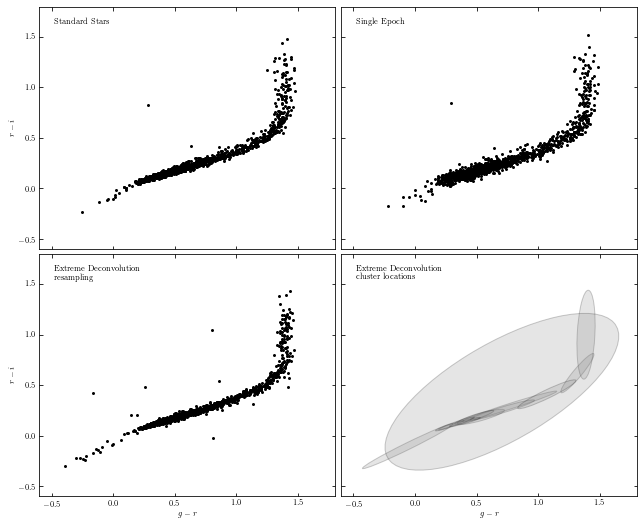

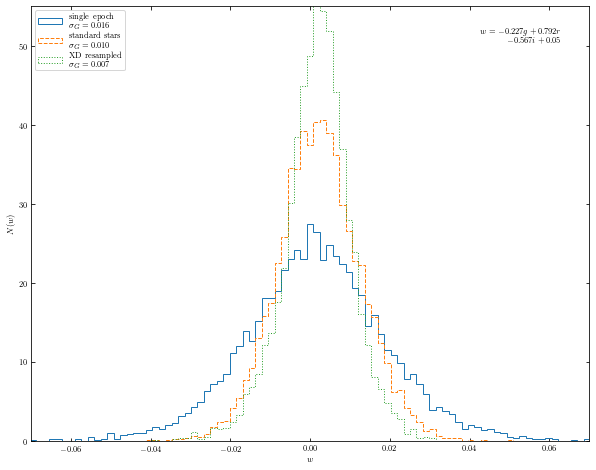

In [42]:
#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.12, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

# only plot 1/10 of the stars for clarity
ax1 = fig.add_subplot(221)
ax1.scatter(Y[::10, 2], Y[::10, 3], s=9, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(X[::10, 2], X[::10, 3], s=9, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(X_sample[::10, 2], X_sample[::10, 3], s=9, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i, 2:4], clf.V[i, 2:4, 2:4], scales=[2],
                 ec='k', fc='gray', alpha=0.2, ax=ax4)

titles = ["Standard Stars", "Single Epoch",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]
ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-0.6, 1.8)
    ax[i].set_ylim(-0.6, 1.8)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$g-r$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$r-i$')

#------------------------------------------------------------
# Second figure: the width of the locus
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

labels = ['single epoch', 'standard stars', 'XD resampled']
linestyles = ['solid', 'dashed', 'dotted']
for data, label, ls in zip((X, Y, X_sample), labels, linestyles):
    g = data[:, 0]
    gr = data[:, 2]
    ri = data[:, 3]

    r = g - gr
    i = r - ri

    mask = (gr > 0.3) & (gr < 1.0)
    g = g[mask]
    r = r[mask]
    i = i[mask]

    w = -0.227 * g + 0.792 * r - 0.567 * i + 0.05

    sigma = sigmaG(w)

    ax.hist(w, bins=np.linspace(-0.08, 0.08, 100), linestyle=ls,
            histtype='step', label=label + '\n\t' + r'$\sigma_G=%.3f$' % sigma,
            density=True)

ax.legend(loc=2)
ax.text(0.95, 0.95, '$w = -0.227g + 0.792r$\n$ - 0.567i + 0.05$',
        transform=ax.transAxes, ha='right', va='top')

ax.set_xlim(-0.07, 0.07)
ax.set_ylim(0, 55)

ax.set_xlabel('$w$')
ax.set_ylabel('$N(w)$')

plt.show()

## Anomaly Detection

ML algorithms suffer in terms of their performance when outliers are not taken care of. 

Bad ideas include 
- dropping them from your sample
- leaving them in, using ML methods, and then ignoring the impact of the outliers


Imagine if a bank did either of these for fradulent credit card transactions...

One efficient way of performing outlier detection in high-dimensional datasets is to use random forests

Isolation forests ‘isolate’ observations by constructing decesion trees:
- randomly selecting a feature and then 
- randomly selecting a split value between the maximum and minimum values of the selected feature

Number of splittings required to isolate a sample = path length from the root node to the terminating node

Path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeable shorter paths for anomalies. 

When a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies - i.e. **linkage-based**

<img src="figures/IsolationForest1.png">

Random forest are **supervised** so why are they showing up here in **unsupervised learning**?
- there's only two labels (outlier/not outlier)
- but you still have to condition the algorithm on a training set (even if it doesn't have labels) 


## Local Outlier Fraction:

LOF uses density-based outlier detection to identify local outliers
- points that are outliers with respect to their local neighborhood, rather than with respect to the global distribution. 

A point is labeled as an outlier if the density around that point is significantly different from the density around its neighbors.
  
The higher the LOF value for an observation, the more anomalous the observation.

Useful because can identify a point that’s an outlier relative to a nearby cluster of points (a local outlier) even if that whole region is an outlying region in the global space of data points.
    - Application SNIa have subclasses that are odd, and even amongst those sub-classes there are real oddballs - these are good to identify because they tell us the most about the physics of the explosion.


<img src="figures/LOF.png">

## Summary of methods

|Method          |Accuracy|Interpretability|Simplicity|Speed|
|----------------|--------|----------------|----------|-----|
|K-nearest Neighbor| H | H | H | M |
|Kernel Density Estimation| H | H | H | H |
|Hierarchical Clustering| H | L | L | L |
||||||
|K-Means| L | M | H | M |
|Max-radius minimization| L | M | M | M |
|Mean shift| M | H | H | M |
|Gaussian Mixture Models| H | M | M | M |
|Extreme Deconvolution| H | H | M | M |

## Unsupervised ML "wisdom"


* Do you have labels that you trust?
    - Why are you using unsupervised methods at all then
* Do you have an a priori reason for there to be $k$ separate groups?
    - k-Means/GMM
* Are your observations really noise and wiping out structure?
    - Extreme deconvolution

* Do you really need clusters or are you trying to get a sense of the underlying density distribution
    - KDEs
* Do you need clustering but your clusters are defined by an overdensity against a background
    - DBSCAN/OPTICS
* Does your sample have some natural hierarchy
    - Hierarchical clustering
    
* Do you care about the stuff that isn't part of some underlying distribution model
    - IsolationForest/LOF

There is no one right answer.

You are looking for structure in your data with unsupervised methods, so the right answer is to **look at your data** - i.e. try a few different things and refine

## In class-exercise:

Train an isolation forest and LOF on a random subset of the color-mag data. 

(For isolation forest, you can use `sklearn.model_selection.train_test_split` to split it into a training set and test set).

In [43]:
## YOUR CODE HERE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [ ]:
Xtrain, Xtest = train_test_split(...
clf = IsolationForest(...
clf.fit(...
y_pred_train = clf.predict(...
y_pred_test = clf.predict(...

#outliers are -1, inliers are 1
y_pred_train[y_pred_train == -1] += 1
y_pred_test[y_pred_test == -1] += 1

color_train = [f'C{i}' for i in y_pred_train]
plt.scatter(Xtrain[:,0], Xtrain[:,1], color=color_train, marker='.', label='Training set')
color_test = [f'C{i}' for i in y_pred_test]
plt.scatter(Xtest[:,0], Xtest[:,1], color=color_test, marker='s', label='Test set')

ax = plt.gca()
ax.legend(fontsize='x-large', loc='lower left')

ax.set_xlabel('Color', fontsize='xx-large')
ax.set_ylabel('Mag', fontsize='xx-large')
ax.set_title('Isolation Forest', fontsize='xx-large');

In [ ]:
clf = LocalOutlierFactor(...
labels = clf.fit_predict(...


#outliers are -1, inliers are 1
labels[labels == -1] += 1


color = [f'C{i}' for i in labels]
plt.scatter(Xt[:,0], Xt[:,1], color=color, marker='o')

ax = plt.gca()

ax.set_xlabel('Color', fontsize='xx-large')
ax.set_ylabel('Mag', fontsize='xx-large')
ax.set_title('Local Outlier Fraction', fontsize='xx-large');